# Cut-off Value



## 0.환경준비

### 1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 불필요한 경고 제거
import warnings
warnings.filterwarnings(action='ignore')

### 2) 데이터 로딩

In [2]:
data_path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/titanic.1.csv'
data = pd.read_csv(data_path)
data.drop(['Ticket','Cabin','AgeGroup','Fare2','Family'], axis = 1, inplace = True)
data.head()

,PassengerId,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Embarked,Mother
0,1,0,3,Mr,male,22.0,1,0,7.2500,S,0
1,2,1,1,Mrs,female,38.0,1,0,71.2833,C,0
2,3,1,3,Miss,female,26.0,0,0,7.9250,S,0
3,4,1,1,Mrs,female,35.0,1,0,53.1000,S,0
4,5,0,3,Mr,male,35.0,0,0,8.0500,S,0


## 2.데이터 준비

### (1) 데이터 정리

* 필요한 변수 생성 / 불필요한 변수 제거

In [3]:
data.drop('PassengerId', axis = 1, inplace = True)

* x, y 분리

In [4]:
target = 'Survived'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (2) 가변수화

In [5]:
dumm_var = ['Pclass','Title','Sex', 'Embarked']

x = pd.get_dummies(x, columns = dumm_var, drop_first = True)
x.head()

,Age,SibSp,Parch,Fare,Mother,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Sex_male,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,0,1
1,38.0,1,0,71.2833,0,0,0,0,0,1,0,0,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,0,0,1
3,35.0,1,0,53.1000,0,0,0,0,0,1,0,0,0,1
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0,1


### (3) 데이터 분할 : train : validation 나누기

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state = 2023)

## 3.모델링

### (1) 학습

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

In [8]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

### (2) 예측

* **.predict_proba** 로 예측하면, **각 클래스별 확률값**으로 반환됩니다.

In [9]:
pred = model.predict_proba(x_val)
pred[:5]

array([[0.87926005, 0.12073995],
       [0.33375427, 0.66624573],
       [0.96179231, 0.03820769],
       [0.80541496, 0.19458504],
       [0.07157932, 0.92842068]])

* (0의 확률) + (1의 확률) = 1 이므로, 둘 중 하나(1의 확률)만 사용합시다. 

In [10]:
# 결과를 실제값과 합쳐서 데이터프레임으로 저장합시다.
result = pd.DataFrame({ 'predicted': pred[:, 1], 'actual': y_val.values})
result.head()

,predicted,actual
0,0.120740,0
1,0.666246,1
2,0.038208,0
3,0.194585,0
4,0.928421,1


## 4.Cut-off 조절

### (1) Cut-off 조절하며 성능 평가결과 저장

* cut-off 값들 준비하기 : np.linspace(시작값, 끝값, 갯수)  
https://numpy.org/doc/stable/reference/generated/numpy.linspace.html

In [11]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [ ]:
# 결과를 저장할 빈 리스트
acc, rec, prec = [],[],[] 

# 0부터 1까지 200개의 cutoff값들 만들기
cutoff_values = np.linspace(0, 1, 200)
cutoff_values

* 값 하나씩 뽑아서 자르고, 그때마다 성능 측정하기
    * 잘라라 : np.where( 조건문, True일 때 반환할 값, False일 때 반환할 값)

In [13]:
for cutoff in cutoff_values :
    # cutoff로 잘라서 0,1로 만들기 
    result['predict01'] = np.where(result['predicted']> cutoff, 1, 0)

    # 평가지표 저장하기.
    acc.append(accuracy_score(result['actual'], result['predict01']))
    rec.append(recall_score(result['actual'], result['predict01'], pos_label = 1))
    prec.append(precision_score(result['actual'], result['predict01'], pos_label = 1))

In [ ]:
acc

### (2) cut off에 따른 성능 평가 그래프

* cut-off를 조절하면서 Accuracy, Recall, Precision 그래프 그려봅시다.

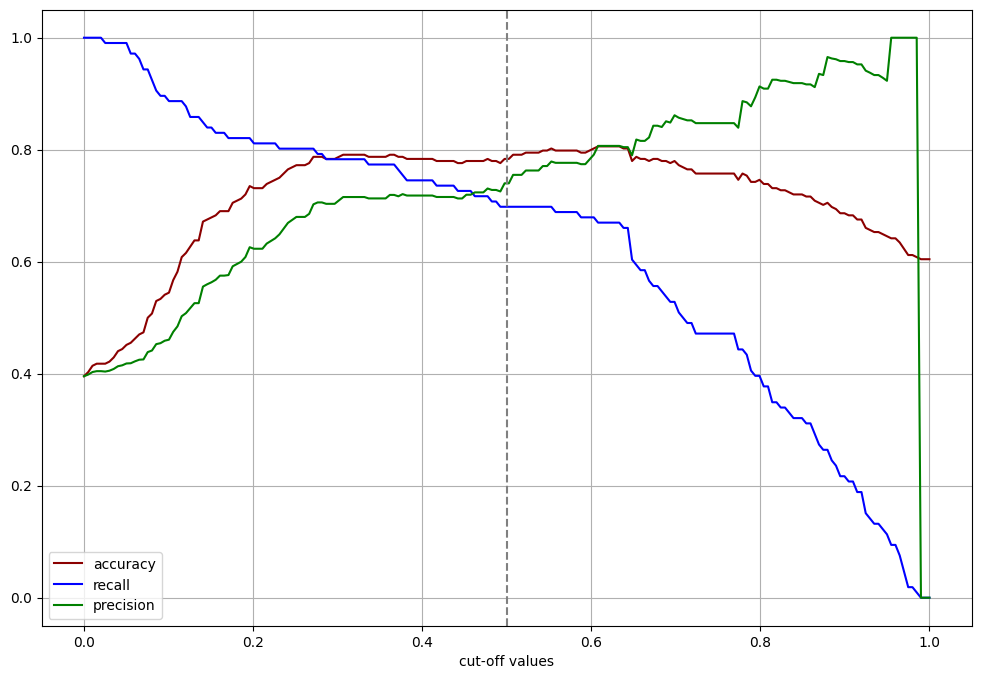

In [15]:
# cut off에 따른 성능 평가 그래프를 그려봅시다.
plt.figure(figsize = (12,8))
plt.plot(cutoff_values, acc, label = 'accuracy', color = 'darkred')
plt.plot(cutoff_values, rec, label = 'recall', color = 'blue')
plt.plot(cutoff_values, prec, label = 'precision', color = 'green')

plt.axvline(0.5, color = 'gray', linestyle = '--')

plt.xlabel('cut-off values')
plt.legend()
plt.grid()
plt.show()

* 위 그래프를 되면, recall과 precision이 서로 trade-off 관계라는 것을 알 수 있습니다.
* Accuracy 최대값과 그때의 cutoff는 어떻게 찾을까요?

In [16]:
# acc의 최대값, acc 최대값일 때 인덱스, 그때의 cut-off value
max(acc), np.argmax(acc), cutoff_values[np.argmax(acc)]

(0.8059701492537313, 121, 0.6080402010050251)

### (3) [추가] precision - recall curve

* 모델을 평가할 때 cutoff와 상관 없이 전반적인 평가를 하는 방법은, cutoff를 조금씩 조절하면서 그린 성능 curve로 비교하고 평가하는 것입니다.
* 대표적인 두가지가 있습니다.
    * AUROC : 민감도, 1-특이도 곡선 (**실제값 관점에서 모델 성능**)
    * Precision-Recall Curve (**Class 0 혹은 1 관점에서 모델의 성능**)
* 둘 다 cuve 아래 **면적**으로 비교하게 됩니다.
* 여기서는 Precision-Recall Curve 만을 다뤄봅니다.

* precision_recall_curve(실제값, 예측값_확률)

In [ ]:
precision, recall, threshold = precision_recall_curve(y_val, result['predicted'])

* PrecisionRecallDisplay.from_predictions(, )  ==> sklearn 1.2부터 변경
    * AP : Curve 아래 면적
    * help : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html#sklearn.metrics.PrecisionRecallDisplay

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

# precision - recall curve
plt.figure(figsize = (10,10))
pr_curve = PrecisionRecallDisplay.from_predictions(y_val, result['predicted'], ax = plt.gca()) # ax = plt.gca() 옵션은, plt.#### 함수들을 함께 사용할 수 있게 해줍니다.
plt.grid()
plt.show()


plot_precision_recall_curve의 결과를 저장하고  
.average_precision 속성을 불러오면, 계산된 아래 면적을 알 수 있습니다.

In [ ]:
pr_curve.average_precision

## 5.실습

* 다음 알고리즘 중 하나를 선정하여 모델을 생성하시오.
    * Logistinc Regression()
    * Decision Tree(max_depth = 4)
    * Random Forest()

* 모델에 대해서 
    * .predict_proba 로 예측 결과를 저장하시오.
    * cutoff를 0부터 1사이에서 0.01씩 증가시키면서 Accuracy curve를 그려봅시다.
    * Accuracy 최대값, 그때의 cutoff를 찾아 봅시다. 

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [20]:
model = DecisionTreeClassifier(max_depth = 4)
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4)

* .predict_proba로 예측

In [21]:
pred = model.predict_proba(x_val)
pred[:3]

array([[0.86238532, 0.13761468],
       [0.41791045, 0.58208955],
       [0.92156863, 0.07843137]])

* 예측결과와 실제 결과를 데이터프레임으로 저장

In [22]:
# 결과를 실제값과 합쳐서 데이터프레임으로 저장합시다.
result = pd.DataFrame({ 'predicted': pred[:, 1], 'actual': y_val.values})
result.head()

,predicted,actual
0,0.137615,0
1,0.582090,1
2,0.078431,0
3,0.137615,0
4,0.949580,1


* cutoff 조절하며 accuracy score 저장하기

In [ ]:
# 결과를 저장할 빈 리스트
acc = [] 

# 0부터 1까지 200개의 cutoff값들 만들기
cutoff_values = np.linspace(0, 1, 200)
cutoff_values

In [25]:
for cutoff in cutoff_values :
    # cutoff로 잘라서 0,1로 만들기 
    result['predict01'] = np.where(result['predicted']> cutoff, 1, 0)

    # 평가지표 저장하기.
    acc.append(accuracy_score(result['actual'], result['predict01']))

* Accuracy Curve 그리기

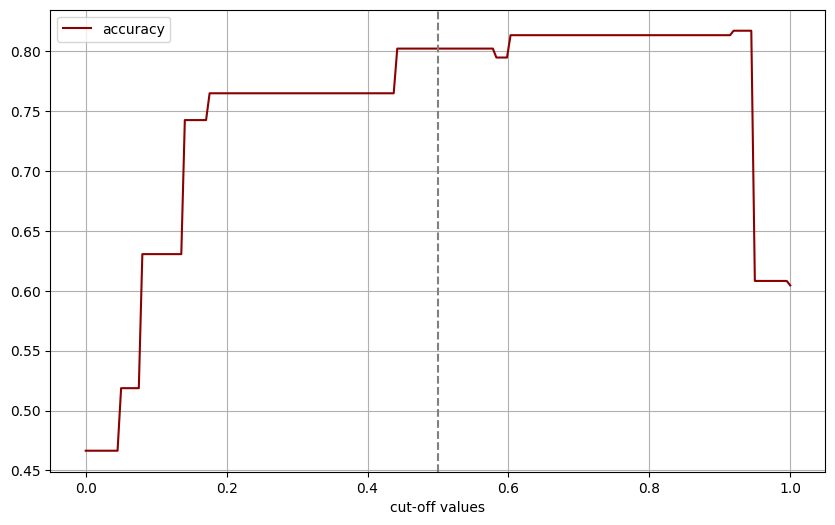

In [27]:
# cut off에 따른 성능 평가 그래프를 그려봅시다.
plt.figure(figsize = (10,6))
plt.plot(cutoff_values, acc, label = 'accuracy', color = 'darkred')

plt.axvline(0.5, color = 'gray', linestyle = '--')

plt.xlabel('cut-off values')
plt.legend()
plt.grid()
plt.show()